In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 셋 불러오기

train = pd.read_csv("../../../data/dacon_parking_demand_dataset/train.csv")
test = pd.read_csv("../../../data/dacon_parking_demand_dataset/test.csv")
sub = pd.read_csv("../../../data/dacon_parking_demand_dataset/sample_submission.csv")
age = pd.read_csv("../../../data/dacon_parking_demand_dataset/age_gender_info.csv")

In [3]:
train.shape, test.shape

((2952, 15), (1022, 14))

### 데이터 셋의 오류 처리

In [4]:
# 오류1번 트레인 셋 처리
# 총세대수와 전용면적별 세대수 합이 다른 단지코드의 값을 -> 전용면적별세대수의 합으로 수정하기

def house_number_correction(df):
    error_1_group = df.groupby("단지코드")[["총세대수"]]
    total_number_house_hold = error_1_group.mean()

    error_2_group = df.groupby("단지코드")["전용면적별세대수"]
    sum_house_hold = error_2_group.sum()

    check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
    different_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

    total_house_index = different_df.index
    total_house_number = []
    for v in different_df.values:
        total_house_number.append(v[1])
    
    for code, value in zip(total_house_index, total_house_number):
         df.loc[df["단지코드"] == code, "총세대수"] = value
    
    return df

train = house_number_correction(train)
test = house_number_correction(test)

In [5]:
error_1_group = train.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = train.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

print(check_df.shape)
check_df

(0, 2)


,총세대수,전용면적별세대수
단지코드,,


In [6]:
error_1_group = test.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = test.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

check_df.shape

(0, 2)

In [7]:
# 오류2번 3번 처리하기

train[(train["단지코드"] == "C2675") | (train["단지코드"] == "C2335") | (train["단지코드"] == "C1327")]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


In [8]:
test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
579,C2675,512,아파트,경기도,국민임대,36.65,130,9.0,A,18476000,154790,0.0,3.0,1016.0
580,C2675,512,아파트,경기도,국민임대,46.90,44,9.0,A,34082000,232200,0.0,3.0,1016.0
581,C2675,512,아파트,경기도,국민임대,46.90,80,9.0,A,34082000,232200,0.0,3.0,1016.0


In [9]:
# 테스트 데이터 셋에서 세개의 코드 데이터를 없애기 (2, 3번 3개 코드 제거)

error_index = test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].index
test = test.drop(index=error_index, axis=0)

In [10]:
# 에러2번의 5개 단지코드 트레인 셋 제거

train_set_error_index = train[(train["단지코드"] =="C2085") | (train["단지코드"] =="C1397") | (train["단지코드"] =="C2431") | (train["단지코드"] =="C1649") | (train["단지코드"] =="C1036")].index
train = train.drop(index=train_set_error_index, axis=0)

In [11]:
# 에러3번의 트레인 셋 7개 단지 코드 제거

train_set_error_index = train[(train["단지코드"] =="C1095") | (train["단지코드"] =="C2051") | (train["단지코드"] =="C1218") | (train["단지코드"] =="C1894") | (train["단지코드"] =="C2483") | (train["단지코드"] =="C1502") | (train["단지코드"] =="C1988")].index
train = train.drop(index=train_set_error_index, axis=0)

### 데이터셋 전처리

In [12]:
# 자격 유형 피처 전처리

test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [13]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [14]:
# 임대보증금 피처 전처리
# 임대보증금이 0인 행의 데이터를 -> 트레인 셋의 중앙값으로 치환

train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

train_df["임대보증금"] = train_df["임대보증금"].fillna(0)
train_df.loc[train_df["임대보증금"] == "-", "임대보증금"] = 0
train_df["임대보증금"] = train_df["임대보증금"].astype(int)
train_df.loc[train_df["임대보증금"] == 0, "임대보증금"] = train_df["임대보증금"].median()

test_df["임대보증금"] = test_df["임대보증금"].fillna(0)
test_df.loc[test_df["임대보증금"] == "-", "임대보증금"] = 0
test_df["임대보증금"] = test_df["임대보증금"].astype(int)
test_df.loc[test_df["임대보증금"] == 0, "임대보증금"] = train_df["임대보증금"].median()

In [15]:
# 레이블 인코딩 -> 원핫 인코딩으로 전환

qualification_type_feature = pd.get_dummies(train_df["자격유형"])
train_df = pd.concat([train_df, qualification_type_feature], axis=1)

qualification_type_feature = pd.get_dummies(test_df["자격유형"])
test_df = pd.concat([test_df, qualification_type_feature], axis=1)

test_df["B"] = 0
test_df["F"] = 0
test_df["O"] = 0

In [16]:
train_df.shape, test_df.shape

((2869, 30), (1008, 29))

In [17]:
# 실거주 세대수 피처 생성

train_df["실거주세대수"] = train_df["총세대수"] - train_df["공가수"].astype(int)
test_df["실거주세대수"] = test_df["총세대수"] - test_df["공가수"].astype(int)

In [18]:
# 세대수 별 주차면수 피처 생성

train_df["세대수비율주차면수"] = (train_df["전용면적별세대수"] / train_df["실거주세대수"]) * train_df["단지내주차면수"]
test_df["세대수비율주차면수"] = (test_df["전용면적별세대수"] / test_df["실거주세대수"]) * test_df["단지내주차면수"]

In [19]:
# 버스정류장 피처 전처리
# 최빈값인 2로 채우기

train_df["도보 10분거리 내 버스정류장 수"] = train_df["도보 10분거리 내 버스정류장 수"].fillna(2)
test_df["도보 10분거리 내 버스정류장 수"] = test_df["도보 10분거리 내 버스정류장 수"].fillna(2)

In [20]:
# 전철역 피처 전처리
# Null 값 0으로 채우기

train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)
test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)

In [22]:
# 지역별 인구수 컬럼 추가

population_df = pd.read_csv("../data/dacon_parking_demand_dataset/age_gender_info.csv")
partial_population_df = population_df.drop(["10대(여자)", "10대(남자)", "20대(여자)", "20대(남자)",
                                            "50대(여자)", "50대(남자)", "100대(여자)", "100대(남자)"], axis=1)
train_df = pd.merge(train_df, population_df, on="지역")
test_df = pd.merge(test_df, population_df, on="지역")

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 0 to 2868
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   임대건물구분                        2869 non-null   object 
 3   지역                            2869 non-null   object 
 4   공급유형                          2869 non-null   object 
 5   전용면적                          2869 non-null   float64
 6   전용면적별세대수                      2869 non-null   int64  
 7   공가수                           2869 non-null   float64
 8   자격유형                          2869 non-null   object 
 9   임대보증금                         2869 non-null   float64
 10  임대료                           2300 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 13  단지내

In [23]:
# 지역별 인구수 나이대 평균 피처 생성

train_df["10대미만(평균)"] = (train_df["10대미만(여자)"] + train_df["10대미만(남자)"]) / 2
train_df["20대(평균)"] = (train_df["20대(여자)"] + train_df["20대(남자)"]) / 2
train_df["30대(평균)"] = (train_df["30대(여자)"] + train_df["30대(남자)"]) / 2
train_df["40대(평균)"] = (train_df["40대(여자)"] + train_df["40대(남자)"]) / 2
train_df["50대(평균)"] = (train_df["50대(여자)"] + train_df["50대(남자)"]) / 2
train_df["60대이상(평균)"] = (train_df["60대(여자)"] + train_df["60대(남자)"] + train_df["70대(여자)"] + train_df["70대(남자)"] +
                              train_df["80대(여자)"] + train_df["80대(남자)"] + train_df["90대(여자)"] + train_df["90대(남자)"] +
                              train_df["100대(여자)"] + train_df["100대(남자)"]) / 10

train_df.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                             0
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)      0
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
A                                 0
B                                 0
C                                 0
D                                 0
E                                 0
F                                 0
G                                 0
H                                 0
I                                 0
J                                 0
K                                 0
L                                 0
M                           

In [24]:
test_df["10대미만(평균)"] = (test_df["10대미만(여자)"] + test_df["10대미만(남자)"]) / 2
test_df["20대(평균)"] = (test_df["20대(여자)"] + test_df["20대(남자)"]) / 2
test_df["30대(평균)"] = (test_df["30대(여자)"] + test_df["30대(남자)"]) / 2
test_df["40대(평균)"] = (test_df["40대(여자)"] + test_df["40대(남자)"]) / 2
test_df["50대(평균)"] = (test_df["50대(여자)"] + test_df["50대(남자)"]) / 2
test_df["60대이상(평균)"] = (test_df["60대(여자)"] + test_df["60대(남자)"] + test_df["70대(여자)"] + test_df["70대(남자)"] +
                              test_df["80대(여자)"] + test_df["80대(남자)"] + test_df["90대(여자)"] + test_df["90대(남자)"] +
                              test_df["100대(여자)"] + test_df["100대(남자)"]) / 10
test_df.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                             0
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)      0
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
A                                 0
C                                 0
D                                 0
E                                 0
G                                 0
H                                 0
I                                 0
J                                 0
K                                 0
L                                 0
M                                 0
N                                 0
B                                 0
F                           

In [25]:
sns.scatterplot(data=train_df, x="50대(여자)", y="전용면적 당 차량등록수", alpha=0.2)

In [26]:
# 원본 Age 피처들 제거

train_df = train_df.drop(["10대미만(여자)","10대미만(남자)","10대(여자)","10대(남자)","20대(여자)","20대(남자)","30대(여자)","30대(남자)",
               "40대(여자)", "40대(남자)","50대(여자)","50대(남자)","60대(여자)","60대(남자)","70대(여자)",
               "70대(남자)", "80대(여자)", "80대(남자)", "90대(여자)", "90대(남자)", "100대(여자)", "100대(남자)"], axis=1)

test_df = test_df.drop(["10대미만(여자)","10대미만(남자)","10대(여자)","10대(남자)","20대(여자)","20대(남자)","30대(여자)","30대(남자)",
               "40대(여자)", "40대(남자)","50대(여자)","50대(남자)","60대(여자)","60대(남자)","70대(여자)",
               "70대(남자)", "80대(여자)", "80대(남자)", "90대(여자)", "90대(남자)", "100대(여자)", "100대(남자)"], axis=1)

In [27]:
# 지역 피처 원핫 인코딩

area_df = pd.get_dummies(train_df["지역"])
area_df = area_df.drop("서울특별시", axis=1)
train_df = pd.concat([train_df, area_df], axis=1)

area_df = pd.get_dummies(test_df["지역"])
test_df = pd.concat([test_df, area_df], axis=1)

In [28]:
# 임대건물 구분 피처 전처리 (아파트, 상가 원핫 인코딩)

train_df = pd.concat([train_df, pd.get_dummies(train_df["임대건물구분"])], axis=1)
train_df.drop("임대건물구분", axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df["임대건물구분"])], axis=1)
test_df.drop("임대건물구분", axis=1, inplace=True)

In [29]:
# 전용 면적 피처를 5의 배수로 전처리

train_df["전용면적"] = train_df["전용면적"] // 5*5
test_df["전용면적"] = test_df["전용면적"] // 5*5

In [30]:
# 세대수 규모 당 총 전용 면적 피처 생성

train_df["세대수 규모 당 총 전용면적"] = train_df["전용면적"] * train_df["전용면적별세대수"]
test_df["세대수 규모 당 총 전용면적"] = test_df["전용면적"] * test_df["전용면적별세대수"]

In [31]:
# 단지별 총 전용 면적 피처 생성

train_df["단지별 총 전용면적"] = train_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)
test_df["단지별 총 전용면적"] = test_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)

In [32]:
# 전용면적 당 차량등록수 피처 생성

train_df["전용면적 당 차량등록수"] = (train_df["세대수 규모 당 총 전용면적"] / train_df["단지별 총 전용면적"]) * train_df["등록차량수"]

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 0 to 2868
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   지역                            2869 non-null   object 
 3   공급유형                          2869 non-null   object 
 4   전용면적                          2869 non-null   float64
 5   전용면적별세대수                      2869 non-null   int64  
 6   공가수                           2869 non-null   float64
 7   자격유형                          2869 non-null   object 
 8   임대보증금                         2869 non-null   float64
 9   임대료                           2300 non-null   object 
 10  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 11  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 12  단지내주차면수                       2869 non-null   float64
 13  등록차

### 이변량 분석
* 독립변수 & 종속변수간의 선형성 시각화
* 이상치 (Outlier) 제거

<AxesSubplot:xlabel='전용면적별세대수', ylabel='전용면적 당 차량등록수'>

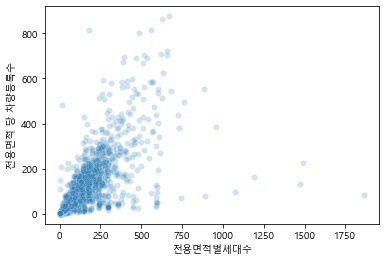

In [34]:
sns.scatterplot(data=train_df, x="전용면적별세대수", y="전용면적 당 차량등록수", alpha=0.2)

In [35]:
# 503, 1871, 1951, 1977, 2023

outlier_index = train_df[train_df["전용면적별세대수"] >= 1000].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [36]:
outlier_index = train_df[(train_df["전용면적별세대수"] <= 30) & (train_df["전용면적 당 차량등록수"] >=400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [37]:
# 301 아웃라이어 제거

train_df[(train_df["전용면적별세대수"] > 150) & (train_df["전용면적 당 차량등록수"] > 750)]

train_df = train_df.drop(index=301, axis=0)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='Count'>

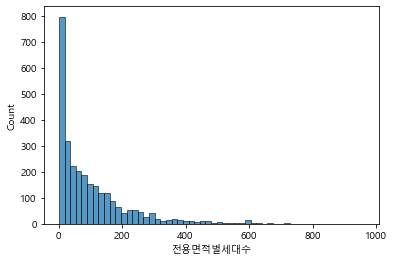

In [38]:
sns.histplot(train_df["전용면적별세대수"])

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='전용면적 당 차량등록수'>

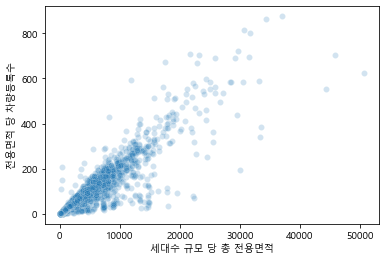

In [39]:
sns.scatterplot(data=train_df, x="세대수 규모 당 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

In [40]:
# 1974, 2141, 2532

outlier_index = train_df[train_df["세대수 규모 당 총 전용면적"] > 40000].index

train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='Count'>

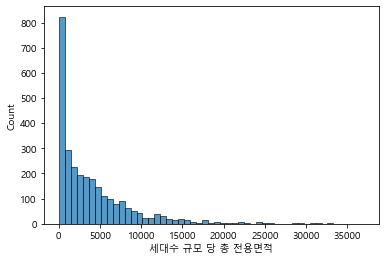

In [41]:
sns.histplot(train_df["세대수 규모 당 총 전용면적"])

<AxesSubplot:xlabel='실거주세대수', ylabel='전용면적 당 차량등록수'>

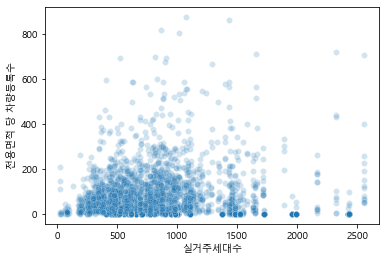

In [42]:
sns.scatterplot(data=train_df, x="실거주세대수", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

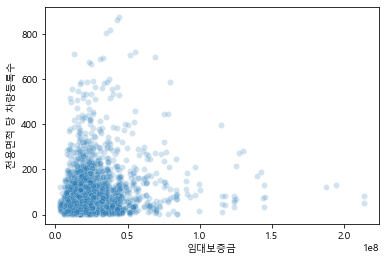

In [46]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

In [47]:
# 임대보증금 아웃라이어 2111, 2812, 2813, 2814 제거

outlier_index = train_df[train_df["임대보증금"] >= 187694000].index
train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='세대수비율주차면수', ylabel='전용면적 당 차량등록수'>

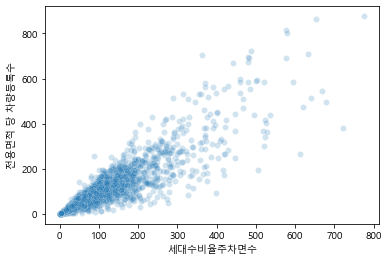

In [60]:
sns.scatterplot(data=train_df, x="세대수비율주차면수", y="전용면적 당 차량등록수", alpha=0.2)

In [61]:
# 세대수비율주차면수 아웃라이어 제거 314

outlier_index = train_df[(train_df["세대수비율주차면수"] >= 700) & (train_df["전용면적 당 차량등록수"] < 400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [63]:
# X_train & X_test 셋 선택

X_train_df_sel = train_df.drop(["단지코드", "상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "전용면적 당 차량등록수", "총세대수"], axis=1)

X_test_df_sel = test_df.drop(["단지코드", "상가", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "총세대수"], axis=1)

y_train_df = train_df["전용면적 당 차량등록수"]

In [64]:
X_train_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '10대미만(평균)', '20대(평균)', '30대(평균)',
       '40대(평균)', '50대(평균)', '60대이상(평균)', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적'],
      dtype='object')

In [65]:
column_names = ['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '10대미만(평균)', '20대(평균)', '30대(평균)',
       '40대(평균)', '50대(평균)', '60대이상(평균)', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적']

X_test_df_sel = X_test_df_sel.reindex(columns=column_names)
X_test_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '10대미만(평균)', '20대(평균)', '30대(평균)',
       '40대(평균)', '50대(평균)', '60대이상(평균)', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적'],
      dtype='object')

In [66]:
X_train_df_sel

,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,A,B,C,D,E,...,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도,아파트,세대수 규모 당 총 전용면적
0,276,17.0,9216000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8280.0
1,60,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2100.0
2,20,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,700.0
3,38,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1710.0
4,19,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,855.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,30,7.0,39000000.0,0.0,2.0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1650.0
2865,156,7.0,49000000.0,0.0,2.0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,10920.0
2866,78,7.0,49000000.0,0.0,2.0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,5460.0
2867,160,7.0,61000000.0,0.0,2.0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,12800.0


In [67]:
X_train_df_log = X_train_df_sel.apply(lambda x: np.log1p(x))
X_test_df_log = X_test_df_sel.apply(lambda x: np.log1p(x))
y_train_df_log = y_train_df.apply(lambda x: np.log1p(x))

### Linear Regression Model Hyper parameter tuning with GridSearchCV

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [71]:
params = {"alpha": [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20, 25, 30, 40, 50]}

elastic_params = {"alpha": [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20, 25, 30, 40, 50],
                 "l1_ratio": [0.1, 0.3, 0.5, 0.7, 1]}


ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()

grid_ridge = GridSearchCV(ridge, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_lasso = GridSearchCV(lasso, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_elastic = GridSearchCV(elastic, param_grid=elastic_params, cv=5, scoring="neg_mean_absolute_error")

grid_ridge.fit(X_train_df_log, y_train_df_log)
grid_lasso.fit(X_train_df_log, y_train_df_log)
grid_elastic.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20, 25, 30,
                                   40, 50],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1]},
             scoring='neg_mean_absolute_error')

In [72]:
grid_ridge.best_params_

{'alpha': 50}

In [99]:
grid_lasso.best_params_

{'alpha': 0.01}

In [101]:
grid_elastic.best_params_

{'alpha': 0.01, 'l1_ratio': 1}

### 랜덤포레스트 모델 및 선형회귀 모델 평가

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 랜덤포레스트 모델 성능평가

rf_reg = RandomForestRegressor(n_jobs=-1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

13.537712986221031

In [75]:
# 랜덤포레스트 이상치처리 및 다중공선성피처제거한 데이터셋으로 학습

model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X_train_df_log, y_train_df_log)
pred = model.predict(X_test_df_log)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub = sub.rename(columns={"code":"단지코드"})
sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("rf_regressor_with_이상치처리_다중공선성피처제거_0722.csv", index=False)

sub_df

,code,num
0,C1072,773.215334
1,C1128,1336.067117
2,C1456,495.212548
3,C1840,416.553862
4,C1332,1208.572777
...,...,...
145,C2456,254.804319
146,C1266,362.613972
147,C2152,37.400837
148,C1267,370.466071


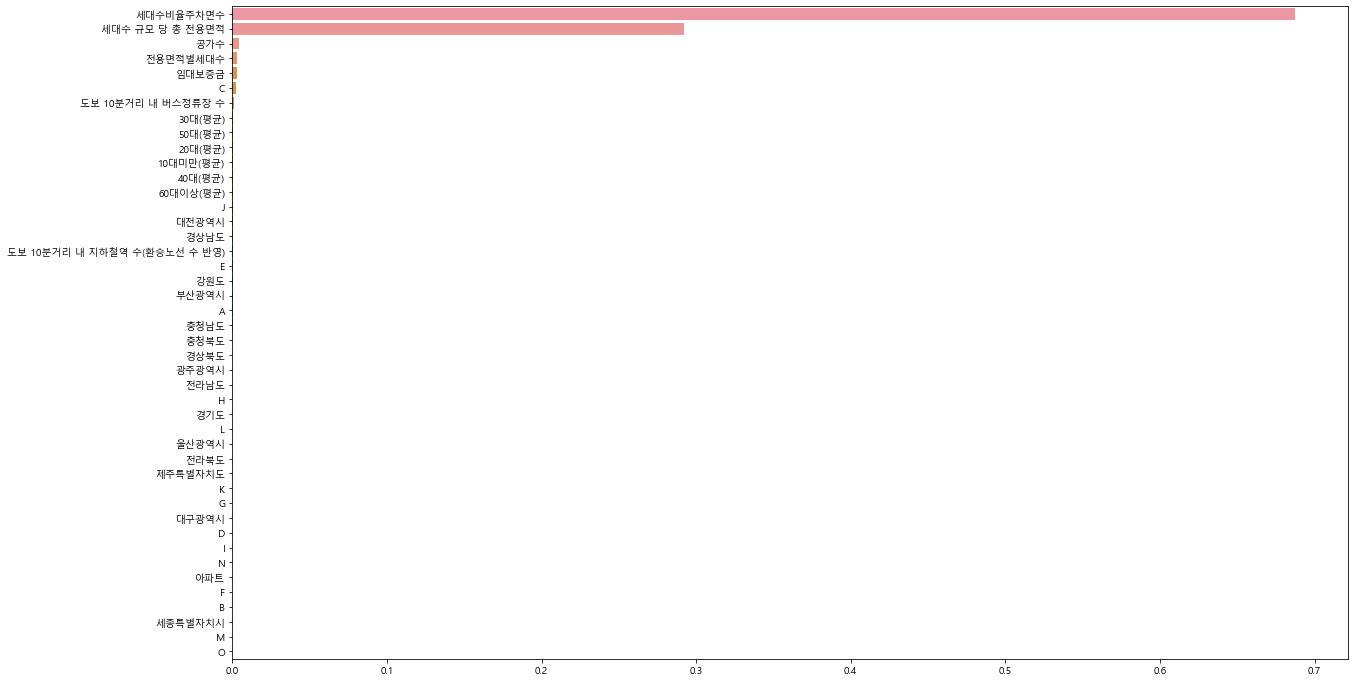

In [76]:
importance = model.feature_importances_
feature_importance = pd.Series(data=importance, index=X_train_df_sel.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [74]:
# 라쏘 모델 성능평가

lasso_model = Lasso(alpha=0.01)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

lasso_model.fit(X_train, y_train)
pred = lasso_model.predict(X_test)


mean_absolute_error(np.expm1(y_test), np.expm1(pred))

16.584434201322495

In [102]:
# 릿지 모델 성능평가

ridge_model = Ridge(alpha=50)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

ridge_model.fit(X_train, y_train)
pred = ridge_model.predict(X_test)


mean_absolute_error(np.expm1(y_test), np.expm1(pred))

15.400509129450096

In [103]:
ridge_model.coef_

array([ 0.05990895, -0.04804463,  0.23496675, -0.0694325 ,  0.00309749,
        0.19112508,  0.03478315, -0.21173291,  0.11420825, -0.05324806,
       -0.01187436, -0.0177364 ,  0.13299994,  0.02990803, -0.08320435,
       -0.06343821, -0.00176308, -0.01212073, -0.04660068, -0.00130568,
        0.55284356,  0.00299904,  0.00236272,  0.00150817,  0.00343955,
        0.0008955 , -0.00331   ,  0.02105802, -0.04419545, -0.11786528,
        0.11135062,  0.07993839,  0.07973481, -0.09912141, -0.07448208,
        0.03088375, -0.01762889,  0.03841968,  0.0263731 ,  0.03425262,
       -0.02461659,  0.01448477, -0.07660118,  0.32960095])

In [104]:
X_train_df_log.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '10대미만(평균)', '20대(평균)', '30대(평균)',
       '40대(평균)', '50대(평균)', '60대이상(평균)', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적'],
      dtype='object')

In [105]:
ridge_model = Ridge(alpha=50)

ridge_model.fit(X_train_df_log, y_train_df_log)
pred = ridge_model.predict(X_test_df_log)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub = sub.rename(columns={"code":"단지코드"})
sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("ridge_with_이상치처리_다중공선성피처제거_인구데이터추가_0723.csv", index=False)

sub_df

,code,num
0,C1072,685.415664
1,C1128,1165.919856
2,C1456,551.074001
3,C1840,486.544283
4,C1332,1107.505285
...,...,...
145,C2456,218.524714
146,C1266,405.731008
147,C2152,35.973355
148,C1267,321.638268


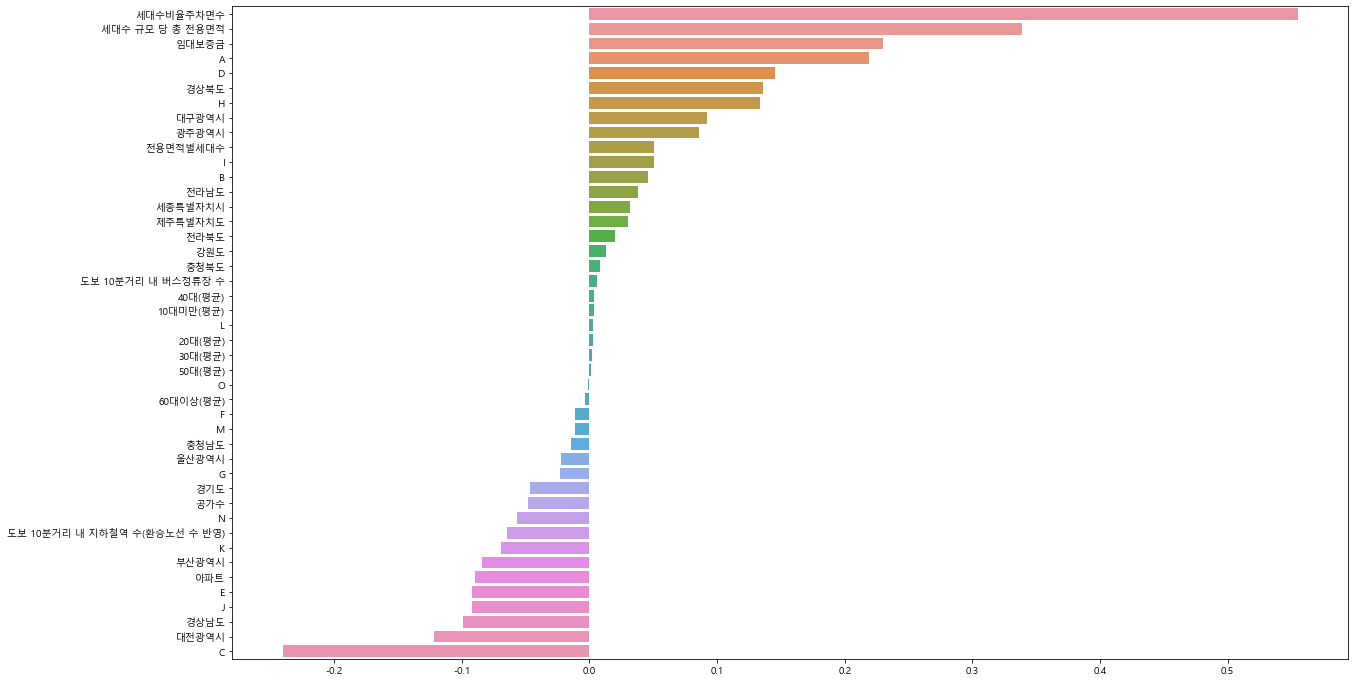

In [106]:
feature_importance = pd.Series(data=ridge_model.coef_, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [82]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [84]:
# LGBM 최적 파라미터 탐색

# params = {"boosting_type": ["gbdt", "dart", "goss", "rf"],
#           "learning_rate": [0.05, 0.1, 0.2, 0.5, 1.0],
#           "n_estimators": [100, 200, 300],
#           "reg_lambda": [1, 5, 10, 20]}

lgbm_reg1 = LGBMRegressor(n_jobs=-1)
grid_model1 = GridSearchCV(lgbm_reg1, param_grid=params, cv=3, scoring="neg_mean_absolute_error")
grid_model1.fit(X_train_df_log, y_train_df_log)

C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\l

C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\l

C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\l

C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\l

C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\l

C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\l

C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\HYUNJUN\anaconda3\envs\likelion\l

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                         'learning_rate': [0.05, 0.1, 0.2, 0.5, 1.0],
                         'n_estimators': [100, 200, 300],
                         'reg_lambda': [1, 5, 10, 20]},
             scoring='neg_mean_absolute_error')

In [85]:
grid_model1.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'n_estimators': 100,
 'reg_lambda': 1}

In [86]:
abs(grid_model1.best_score_)

0.19916298221831422

In [87]:
best_model = grid_model1.best_estimator_

pred = best_model.predict(X_test_df_log)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub = sub.rename(columns={"code":"단지코드"})
sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})

sub_df

,code,num
0,C1072,776.101199
1,C1128,1357.608854
2,C1456,542.389450
3,C1840,413.952929
4,C1332,1201.016978
...,...,...
145,C2456,249.051705
146,C1266,394.365397
147,C2152,46.569408
148,C1267,379.793939


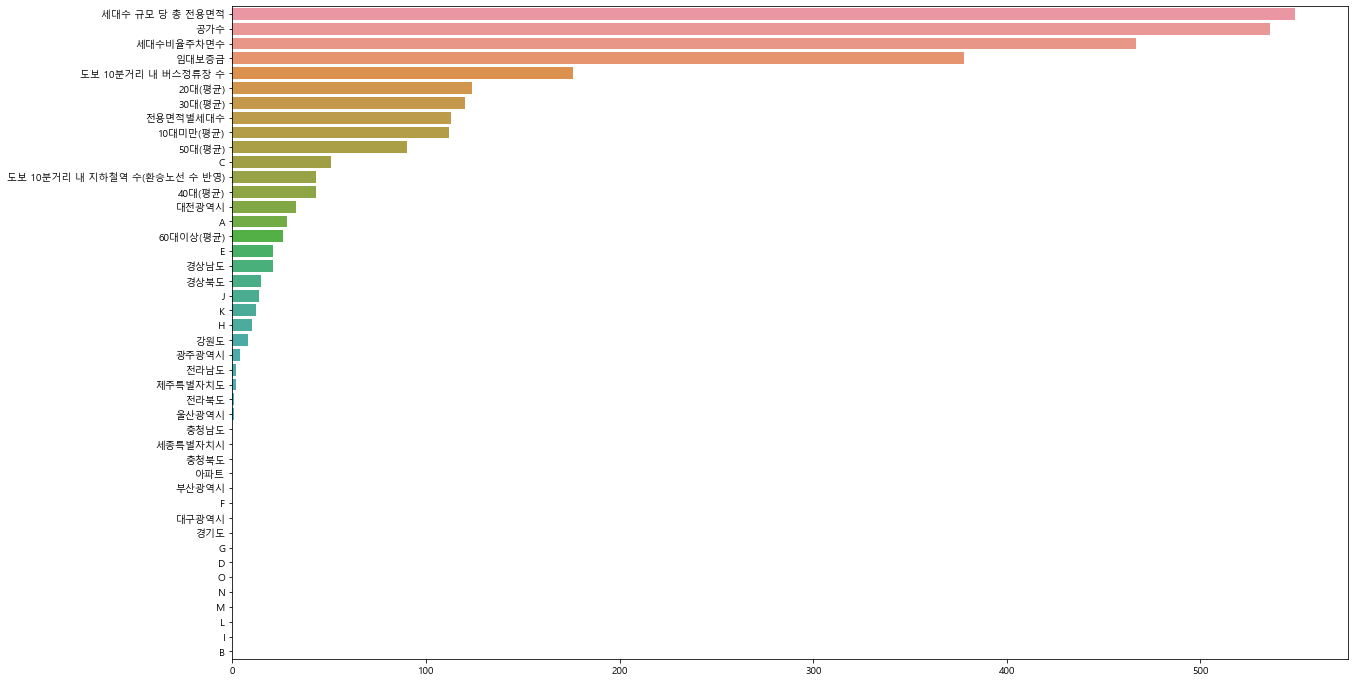

In [88]:
feature_importance = pd.Series(data=best_model.feature_importances_, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [90]:
from xgboost import XGBRegressor

In [91]:
# XGBoost 모델 성능평가

xgb_reg = XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

xgb_reg.fit(X_train, y_train)
pred = xgb_reg.predict(X_test)


mean_absolute_error(np.expm1(y_test), np.expm1(pred))

10.63320224378703

In [92]:
xgb_reg.feature_importances_

array([1.1561083e-03, 3.4095561e-03, 2.0227099e-03, 3.4236887e-03,
       1.7949548e-03, 1.5751029e-03, 4.8874493e-04, 8.8567220e-02,
       1.4444272e-04, 9.3801343e-04, 0.0000000e+00, 3.2996801e-03,
       1.5334232e-03, 9.2757499e-04, 1.0051188e-02, 3.1982113e-03,
       7.8162970e-04, 5.0418527e-04, 1.2856651e-03, 0.0000000e+00,
       7.5798911e-01, 2.0857104e-03, 2.9744816e-03, 3.7712231e-03,
       2.9626526e-03, 3.2851018e-03, 1.2908205e-03, 2.3000245e-03,
       0.0000000e+00, 4.5128930e-03, 2.6826679e-03, 1.5302651e-03,
       0.0000000e+00, 3.8372818e-03, 0.0000000e+00, 0.0000000e+00,
       1.6025940e-03, 2.8941864e-03, 5.5820839e-03, 1.6617533e-03,
       4.5955777e-03, 2.0358402e-03, 0.0000000e+00, 6.7303680e-02],
      dtype=float32)

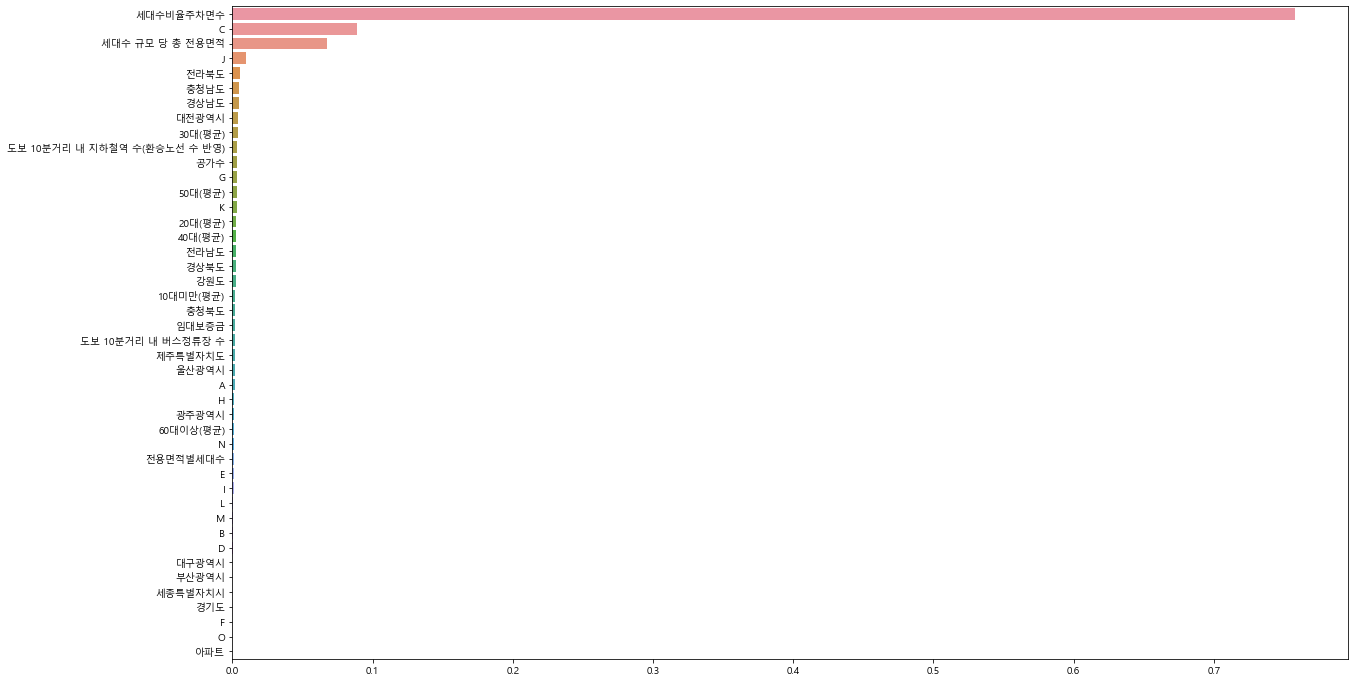

In [93]:
feature_importance = pd.Series(data=xgb_reg.feature_importances_, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [94]:
from sklearn.ensemble import GradientBoostingRegressor

In [95]:
# GradientBoostingRegressor 성능평가

gb_reg = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05)

gb_reg.fit(X_train, y_train)
pred = gb_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

9.792939143309395

In [96]:
gb_reg.feature_importances_

array([8.98174216e-04, 5.51200214e-03, 5.80751385e-03, 2.53027027e-04,
       1.50168825e-03, 2.13282372e-04, 2.92923458e-05, 5.21289600e-03,
       4.94206105e-05, 1.82739202e-04, 9.06927753e-05, 5.38700044e-05,
       1.05308862e-04, 9.29340354e-06, 1.35336779e-04, 4.52151870e-05,
       4.65522769e-05, 9.93570424e-06, 1.30716701e-05, 0.00000000e+00,
       7.20119698e-01, 8.02372579e-04, 6.52316123e-04, 2.72348492e-04,
       1.87334849e-04, 6.59733629e-04, 2.06877686e-04, 2.43089280e-04,
       4.39116611e-05, 2.42419812e-04, 2.60722115e-04, 7.98257866e-05,
       3.82402335e-05, 3.22416324e-04, 6.14416863e-05, 1.99309297e-06,
       5.75921484e-05, 8.74860160e-05, 1.67411964e-04, 1.26868828e-05,
       7.75334754e-05, 6.59590945e-05, 0.00000000e+00, 2.55167277e-01])

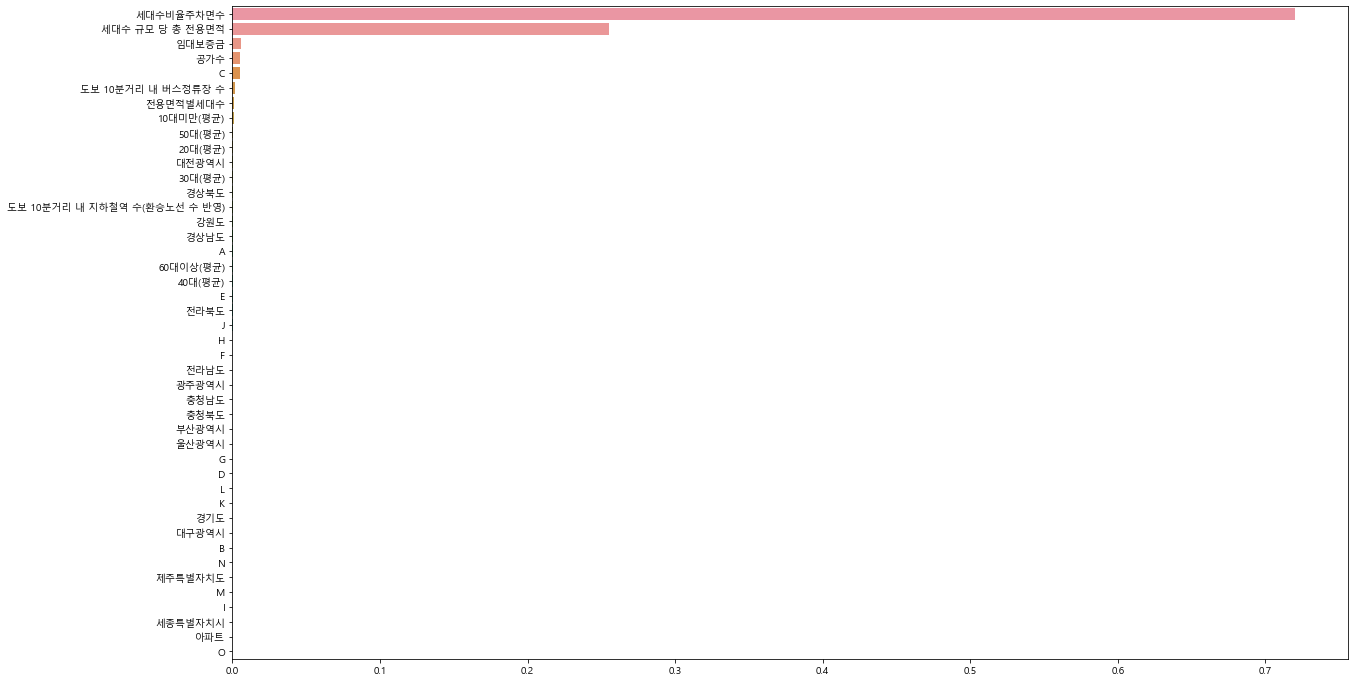

In [97]:
feature_importance = pd.Series(data=gb_reg.feature_importances_, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()